In [307]:
%load_ext autotime

import pandas as pd
import numpy as np

import pyspark as spark
import os
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home'

from dateutil.parser import parse

import matplotlib.pyplot as plt
import seaborn as sn

import re

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.11 s (started: 2021-10-11 19:12:19 +07:00)


# Excersise 2

In [274]:
df = pd.read_csv('quotes.csv')
df.head()

,Tacgia,Link,Namsinh,Quote
0,Albert Einstein,/author/Albert-Einstein,"March 14, 1879","['""The world as we have created it is a proces..."
1,Alexandre Dumas fils,/author/Alexandre-Dumas-fils,"July 27, 1824","['""The difference between genius and stupidity..."
2,Alfred Tennyson,/author/Alfred-Tennyson,"August 06, 1809","['""If I had a flower for every time I thought ..."
3,Allen Saunders,/author/Allen-Saunders,"April 24, 1899","['""Life is what happens to us while we are mak..."
4,André Gide,/author/Andre-Gide,"November 22, 1869","['""It is better to be hated for what you are t..."


time: 17.4 ms (started: 2021-10-10 22:42:46 +07:00)


In [275]:
df['Tacgia']=df['Tacgia'].astype('string')
df['Link']=df['Link'].astype('string')
df['Quote'] = pd.eval(df['Quote'])

# Convert column 'Namsinh' to timestamp and fill NaN by most frequence value
top_birth = df.describe().loc['top','Namsinh']

df['Namsinh'] = df['Namsinh'].fillna(top_birth)
df['Namsinh'] = df['Namsinh'].apply(lambda x: parse(x))

# Add column 'Tuoi' base on 'Namsinh'
df['Tuoi'] = (pd.Timestamp('now')-df['Namsinh']).astype('<m8[Y]')

print(df.dtypes)
df.head()

Tacgia             string
Link               string
Namsinh    datetime64[ns]
Quote              object
Tuoi              float64
dtype: object


,Tacgia,Link,Namsinh,Quote,Tuoi
0,Albert Einstein,/author/Albert-Einstein,1879-03-14,"[""The world as we have created it is a process...",142.0
1,Alexandre Dumas fils,/author/Alexandre-Dumas-fils,1824-07-27,"[""The difference between genius and stupidity ...",197.0
2,Alfred Tennyson,/author/Alfred-Tennyson,1809-08-06,"[""If I had a flower for every time I thought o...",212.0
3,Allen Saunders,/author/Allen-Saunders,1899-04-24,"[""Life is what happens to us while we are maki...",122.0
4,André Gide,/author/Andre-Gide,1869-11-22,"[""It is better to be hated for what you are th...",151.0


time: 49 ms (started: 2021-10-10 22:42:46 +07:00)


In [276]:
for i in range(df.shape[0]):
   print(f'Author: {df.loc[i].Tacgia:30} Number of quotes: {len(df.loc[i].Quote)}')

Author: Albert Einstein                Number of quotes: 10
Author: Alexandre Dumas fils           Number of quotes: 1
Author: Alfred Tennyson                Number of quotes: 1
Author: Allen Saunders                 Number of quotes: 1
Author: André Gide                     Number of quotes: 1
Author: Ayn Rand                       Number of quotes: 1
Author: Bob Marley                     Number of quotes: 3
Author: C.S. Lewis                     Number of quotes: 5
Author: Charles Bukowski               Number of quotes: 2
Author: Charles M. Schulz              Number of quotes: 1
Author: Douglas Adams                  Number of quotes: 1
Author: Dr. Seuss                      Number of quotes: 6
Author: E.E. Cummings                  Number of quotes: 1
Author: Eleanor Roosevelt              Number of quotes: 2
Author: Elie Wiesel                    Number of quotes: 1
Author: Ernest Hemingway               Number of quotes: 2
Author: Friedrich Nietzsche            Number of quotes

In [277]:
oldest = df[df.Tuoi == df.Tuoi.max()]
youngest = df[df.Tuoi == df.Tuoi.min()]

print('The average age of authors :',df['Tuoi'].describe()['mean'])

print(f'The oldest author: {oldest.iloc[0,0]}\n Day of birth: {oldest.iloc[0,2]} ({oldest.iloc[0,4]})')

print(f'The youngest author: {youngest.iloc[0,0]}\n Day of birth: {youngest.iloc[0,2]} ({youngest.iloc[0,4]})')

The average age of authors : 117.22
The oldest author: Jane Austen
 Day of birth: 1775-12-16 00:00:00 (245.0)
The youngest author: Stephenie Meyer
 Day of birth: 1973-12-24 00:00:00 (47.0)
time: 17.7 ms (started: 2021-10-10 22:42:49 +07:00)


In [278]:
quotes=[]
for i in df['Quote']:
   for j in i:
      quotes.append(j)

time: 1.28 ms (started: 2021-10-10 22:42:50 +07:00)


In [279]:
import string


longest = max(quotes,key=len)
print(f'The longest quote :\n\t{longest}\nNo.: {len(longest.split(" "))} words')

shortest = min(quotes,key=len)
print(f'\nThe shortest quote :\n\t{shortest}\nNo.: {len(shortest.split(" "))} words')

words = []
for i in quotes:
   regex = re.compile('[%s]' % re.escape(string.punctuation))
   i = regex.sub(' ',i)
   for j in i.split(' '):
      if len(j)>0:
         words.append(j)

print('\nOn average, each quote have',len(words)/len(quotes),'words')

The longest quote :
	"This life is what you make it. No matter what, you're going to mess up sometimes, it's a universal truth. But the good part is you get to decide how you're going to mess it up. Girls will be your friends - they'll act like it anyway. But just remember, some come, some go. The ones that stay with you through everything - they're your true best friends. Don't let go of them. Also remember, sisters make the best friends in the world. As for lovers, well, they'll come and go too. And baby, I hate to say it, most of them - actually pretty much all of them are going to break your heart, but you can't give up because if you give up, you'll never find your soulmate. You'll never find that half who makes you whole and that goes for everything. Just because you fail once, doesn't mean you're gonna fail at everything. Keep trying, hold on, and always, always, always believe in yourself, because if you don't, then who will, sweetie? So keep your head high, keep your chin up, 

In [295]:
sc = spark.SparkContext.getOrCreate()
words_sc = sc.parallelize(words)
words_count = words_sc.map(lambda x:(x.lower(),1)).reduceByKey(lambda a,b: a+ b).sortBy(lambda x: x[1]).collect()

words_count

[('process', 1),
 ('cannot', 1),
 ('rather', 1),
 ('flower', 1),
 ('question', 1),
 ('perfect', 1),
 ('cup', 1),
 ('intact', 1),
 ('start', 1),
 ('sun', 1),
 ('attempt', 1),
 ('crazy', 1),
 ('horrible', 1),
 ('water', 1),
 ('ugliness', 1),
 ('faith', 1),
 ('loyal', 1),
 ('unhappy', 1),
 ('jojen', 1),
 ('yours', 1),
 ('far', 1),
 ('impossible', 1),
 ('why', 1),
 ('strayed', 1),
 ('diggory', 1),
 ('treated', 1),
 ('lost', 1),
 ('novel', 1),
 ('notion', 1),
 ('admiration', 1),
 ('declare', 1),
 ('excellent', 1),
 ('confirms', 1),
 ('belief', 1),
 ('inconsistency', 1),
 ('misinformed', 1),
 ('sometimes', 1),
 ('girls', 1),
 ('soulmate', 1),
 ('once', 1),
 ('eventually', 1),
 ('space', 1),
 ('kisses', 1),
 ('listens', 1),
 ('praise', 1),
 ('follows', 1),
 ('putting', 1),
 ('sixty', 1),
 ('finish', 1),
 ('spirit', 1),
 ('madly', 1),
 ('anytime', 1),
 ('trouble', 1),
 ('10', 1),
 ('work', 1),
 ('free', 1),
 ('z', 1),
 ('bicycle', 1),
 ('terms', 1),
 ('hated', 1),
 ('mistakes', 1),
 ('knows', 

time: 403 ms (started: 2021-10-10 22:56:52 +07:00)


In [304]:
freq_min = words_count[0][1]
freq_max = words_count[-1][1]
words_min = []
words_max = []

for i in words_count:
   if i[1] == freq_min:
      words_min.append(i[0])
   if i[1] == freq_max:
      words_max.append(i[0])

print(f'The least common word(s): {words_min}\nOccurrence: {freq_min} \nNo.: {len(words_min)}')
print(f'\nThe most common word(s): {words_max}\nOccurrence: {freq_max} \nNo.: {len(words_max)}')

The least common word(s): ['process', 'cannot', 'rather', 'flower', 'question', 'perfect', 'cup', 'intact', 'start', 'sun', 'attempt', 'crazy', 'horrible', 'water', 'ugliness', 'faith', 'loyal', 'unhappy', 'jojen', 'yours', 'far', 'impossible', 'why', 'strayed', 'diggory', 'treated', 'lost', 'novel', 'notion', 'admiration', 'declare', 'excellent', 'confirms', 'belief', 'inconsistency', 'misinformed', 'sometimes', 'girls', 'soulmate', 'once', 'eventually', 'space', 'kisses', 'listens', 'praise', 'follows', 'putting', 'sixty', 'finish', 'spirit', 'madly', 'anytime', 'trouble', '10', 'work', 'free', 'z', 'bicycle', 'terms', 'hated', 'mistakes', 'knows', 'god', 'poured', 'need', 'gone', 'intended', 'today', 'truer', 'ahead', 'courage', 'typewriter', 'church', 'christian', 'garage', 'accept', 'wish', 'whenever', 'show', 'failing', 'sighed', 'seem', 'intolerably', 'nature', 'few', 'still', 'dissatisfied', 'dependence', 'black', 'someday', 'written', 'stay', 'break', 'lies', 'devil', 'sleepy'

In [312]:
df['Quote_len'] = df['Quote'].apply(lambda x: len(x))

time: 1.93 ms (started: 2021-10-11 19:16:33 +07:00)


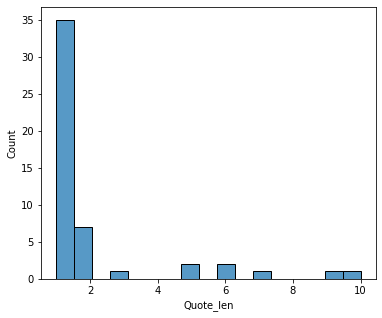

time: 153 ms (started: 2021-10-11 19:23:40 +07:00)


In [321]:
plt.figure(figsize=(6,5))
sn.histplot(df['Quote_len'])
plt.show()

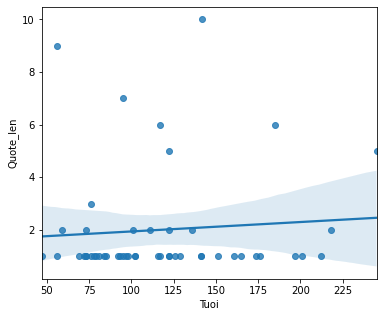

time: 239 ms (started: 2021-10-11 19:23:44 +07:00)


In [322]:
plt.figure(figsize=(6,5))
sn.regplot(data=df,x='Tuoi',y='Quote_len')
plt.show()

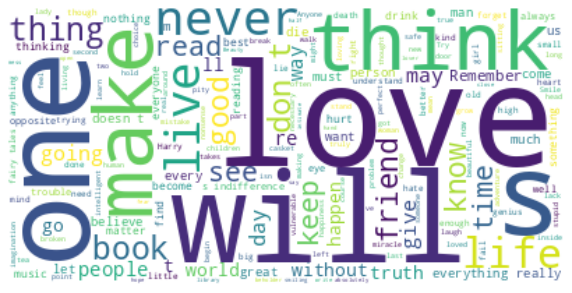

time: 716 ms (started: 2021-10-11 19:30:18 +07:00)


In [329]:
from wordcloud import STOPWORDS, WordCloud

my_stopwords = set(STOPWORDS)
words_collect = re.sub('\'','',str(words))
wc1 = WordCloud(stopwords = my_stopwords,background_color='white')
wc1.generate(words_collect)
plt.figure(figsize =(10, 8))
plt.imshow(wc1, interpolation = 'bilinear')
plt.axis('off')
plt.show()